## Set up

In [ ]:
!pip install -q transformers

In [ ]:
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow import keras
from transformers import RobertaTokenizer, TFRobertaModel
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.regularizers import l1, l2



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
home_dir = Path('/content/drive/MyDrive/266 Final Project/Code')
train_path = home_dir / 'data' / 'train'
val_path = home_dir / 'data' / 'val'
test_path = home_dir / 'data' / 'test'

In [ ]:
#roberta model
#https://huggingface.co/docs/transformers/model_doc/roberta#transformers.RobertaForSequenceClassification

roberta_tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
roberta_model = TFRobertaModel.from_pretrained("roberta-base")

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'roberta.embeddings.position_ids', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [ ]:
results = {}

for category in (['em', 'in', 'ex', 'ex_aug']):
    X_train = pd.read_csv(train_path / f'X_{category}.csv', delimiter=',')
    # X_train = X_train['response_post']

    results[f'{category}_seeker_wordcount'] = X_train['seeker_post'].str.split().apply(len).describe()
    results[f'{category}_seeker_token_count'] = X_train['seeker_post'].apply(lambda x: len(roberta_tokenizer.tokenize(x))).describe()
    results[f'{category}_response_wordcount'] = X_train['response_post'].str.split().apply(len).describe()
    results[f'{category}_response_token_count'] = X_train['response_post'].apply(lambda x: len(roberta_tokenizer.tokenize(x))).describe()

    results[f'{category}_seeker_wordcount'] = X_train['seeker_post'].str.split().apply(len).describe()
    results[f'{category}_seeker_token_count'] = X_train['seeker_post'].apply(lambda x: len(roberta_tokenizer.tokenize(x))).describe()


summary_table = pd.DataFrame(results)

summary_table = summary_table.transpose()

summary_table



,count,mean,std,min,25%,50%,75%,max
em_seeker_wordcount,1256.0,35.428344,26.695890,7.0,18.00,30.5,46.00,208.0
em_seeker_token_count,1256.0,42.770701,31.262237,8.0,22.00,36.0,55.00,252.0
em_response_wordcount,1256.0,48.544586,73.467111,5.0,14.00,29.0,59.00,1811.0
em_response_token_count,1256.0,57.561306,85.778382,5.0,18.00,34.0,69.25,2099.0
in_seeker_wordcount,1850.0,34.620000,25.158684,6.0,18.00,30.0,45.00,216.0
in_seeker_token_count,1850.0,42.093514,29.506275,8.0,22.25,36.0,54.00,252.0
in_response_wordcount,1850.0,47.835676,69.720736,5.0,14.00,28.0,58.00,1811.0
in_response_token_count,1850.0,57.045405,82.437554,5.0,17.00,34.0,69.00,2121.0
ex_seeker_wordcount,576.0,34.776042,24.005655,6.0,18.00,32.0,44.00,186.0
ex_seeker_token_count,576.0,42.409722,28.037283,8.0,23.00,39.0,53.00,222.0


In [ ]:
MAX_LENGTH = 200
FEATURES = 'response_post'

In [ ]:
def prepare_text(row,seeker_length=36):
    seeker_words = row['seeker_post'].split()[:seeker_length]
    padded_seeker = ' '.join(seeker_words)  # no padding of empty characters
    combined_text = padded_seeker + ' [SEP] ' + row['response_post']
    return combined_text

In [ ]:
def get_target_vectors(category):
    y_train = pd.read_csv((train_path / f'y_{category}.csv'), delimiter=',')
    y_val = pd.read_csv((val_path / f'y_{category}.csv'), delimiter=',')
    y_test = pd.read_csv((test_path / f'y_{category}.csv'), delimiter=',')

    y_train = y_train['empathy']
    y_val = y_val['empathy']
    y_test = y_test['empathy']

    return y_train, y_val, y_test


#no manual adjustment of token_type_ids; everything will be 0
def csv_to_encodings(category, features=FEATURES, max_length=MAX_LENGTH):
    #chunk and pad seeker_post, then add [SEP] to join with response_post

    X_train = pd.read_csv(train_path / f'X_{category}.csv', delimiter=',')
    # X_train = X_train[features]
    X_train_combined = X_train.apply(prepare_text, axis=1)
    train_encodings = roberta_tokenizer(list(X_train_combined), truncation=True, padding=True, max_length=max_length, return_tensors='tf')

    X_val = pd.read_csv(val_path / f'X_{category}.csv', delimiter=',')
    # X_val = X_val[features]
    X_val_combined = X_val.apply(prepare_text, axis=1)
    val_encodings = roberta_tokenizer(list(X_val_combined), truncation=True, padding=True, max_length=max_length, return_tensors='tf')

    X_test = pd.read_csv(test_path / f'X_{category}.csv', delimiter=',')
    # X_test = X_test[features]
    X_test_combined = X_test.apply(prepare_text, axis=1)
    test_encodings = roberta_tokenizer(list(X_test_combined), truncation=True, padding=True, max_length=max_length, return_tensors='tf')

    return train_encodings, val_encodings, test_encodings

### chunking considerations

## Models

In [ ]:
def create_roberta_model(model=roberta_model,max_length = MAX_LENGTH,
                                 hidden_size = 100,
                                 dropout=0.3,
                                 learning_rate=0.0005):


    model.trainable = False


    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
    # token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

    roberta_inputs = {'input_ids': input_ids,
                #    'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    roberta_out = model(roberta_inputs)

    #pooler_token = bert_out[1]
    cls_token = roberta_out[0][:, 0, :]

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(cls_token)


    hidden = tf.keras.layers.Dropout(dropout)(hidden)


    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer')(hidden)

    classification_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[classification])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(),
                                 metrics='accuracy')



    return classification_model

In [ ]:
def run_model(category):
    y_train, y_val, y_test = get_target_vectors(category)

    train_encodings, val_encodings, test_encodings = csv_to_encodings(category)

    print(f'y_train value counts:\n{y_train.value_counts()}')

    print(f'train_encodings:\n{train_encodings}')

    classification = create_roberta_model(model=roberta_model)
    classification_history = classification.fit([train_encodings.input_ids, train_encodings.attention_mask],
                                                  y_train,
                                                  validation_data=([val_encodings.input_ids, val_encodings.attention_mask],
                                                  y_val),
                                                  batch_size=8,
                                                  epochs=10,
                                                  #class_weight=class_weight
                                                  )

    metrics_columns = ['Category', 'Accuracy', 'Precision', 'Recall', 'F1 Score']

    predictions = classification.predict([test_encodings.input_ids, test_encodings.attention_mask])
    predictions = (predictions >= 0.5).astype(int)


    accuracy = accuracy_score(y_test, predictions)
    print(f"accuracy for test: {accuracy}")
    recall = recall_score(y_test, predictions)
    print(f"recall for test: {recall}")
    precision = precision_score(y_test, predictions)
    print(f"precision for test: {precision}")
    f1 = f1_score(y_test, predictions)
    print(f"f1 score for test: {f1}")

    conf_matrix = confusion_matrix(y_test, predictions)
    print(conf_matrix)

    sns.set(font_scale=1.2)
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', annot_kws={"size": 16}, cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{category} Confusion Matrix')
    plt.show()


    metrics = {
        'Category': f'{category}short',
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }
    metrics = pd.DataFrame([metrics], columns=metrics_columns)
    return metrics

y_train value counts:
0    629
1    627
Name: empathy, dtype: int64
train_encodings:
{'input_ids': <tf.Tensor: shape=(1256, 200), dtype=int32, numpy=
array([[    0,   100,   524, ...,     1,     1,     1],
       [    0,  2387, 18229, ...,     1,     1,     1],
       [    0,   100,  4157, ...,     1,     1,     1],
       ...,
       [    0,   100, 18774, ...,     1,     1,     1],
       [    0,  2387,    86, ...,    50,   608,     2],
       [    0,  2264,   109, ...,     1,     1,     1]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1256, 200), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}
Epoch 1/10
157/157 [==============================] - 41s 190ms/step - loss: 0.7113 - accuracy: 0.5303 - val_loss: 0.6741 - val_accuracy: 0.6181
Epoch 2/10
157/157 [==============================] 

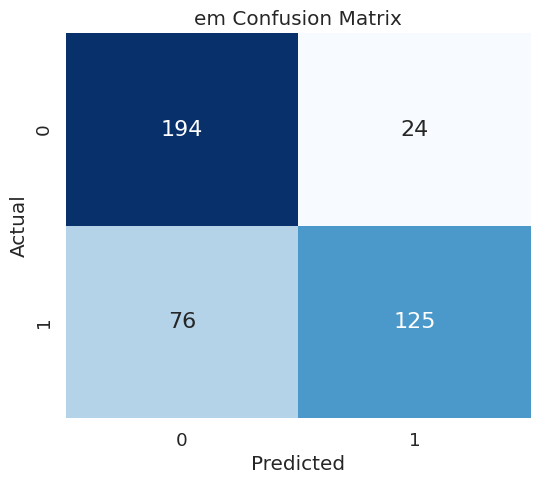

In [ ]:
em_metrics = run_model('em')

y_train value counts:
0    972
1    878
Name: empathy, dtype: int64
train_encodings:
{'input_ids': <tf.Tensor: shape=(1850, 200), dtype=int32, numpy=
array([[    0, 29774, 10887, ...,     1,     1,     1],
       [    0,  2387, 19960, ...,     1,     1,     1],
       [    0,   565,  7651, ...,  9041, 37249,     2],
       ...,
       [    0,  2387,   809, ...,     1,     1,     1],
       [    0,  3684,    14, ...,     1,     1,     1],
       [    0,   118,  2220, ...,     1,     1,     1]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1850, 200), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}
Epoch 1/10
232/232 [==============================] - 69s 183ms/step - loss: 0.6930 - accuracy: 0.5454 - val_loss: 0.6676 - val_accuracy: 0.6726
Epoch 2/10
232/232 [==============================] 

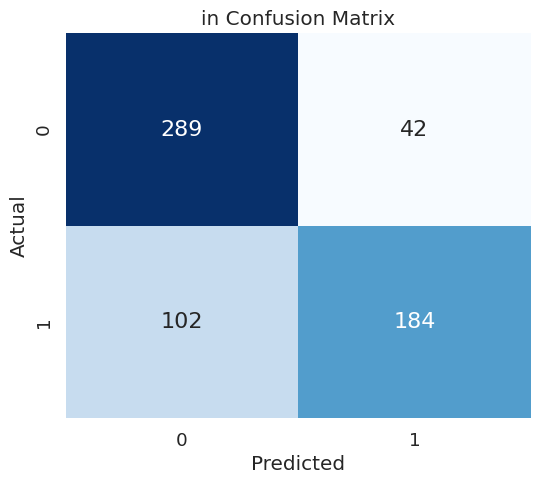

In [ ]:
in_metrics = run_model('in')

y_train value counts:
1    294
0    282
Name: empathy, dtype: int64
train_encodings:
{'input_ids': <tf.Tensor: shape=(576, 200), dtype=int32, numpy=
array([[    0,  6209,    24, ...,     1,     1,     1],
       [    0, 44823,    42, ...,     1,     1,     1],
       [    0,  6209,     5, ...,     1,     1,     1],
       ...,
       [    0, 28780,     4, ...,     1,     1,     1],
       [    0,   100,   362, ...,     1,     1,     1],
       [    0,   100,   619, ...,   198,     4,     2]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(576, 200), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int32)>}
Epoch 1/10
72/72 [==============================] - 22s 182ms/step - loss: 0.7290 - accuracy: 0.4792 - val_loss: 0.6861 - val_accuracy: 0.5052
Epoch 2/10
72/72 [==============================] - 11s 

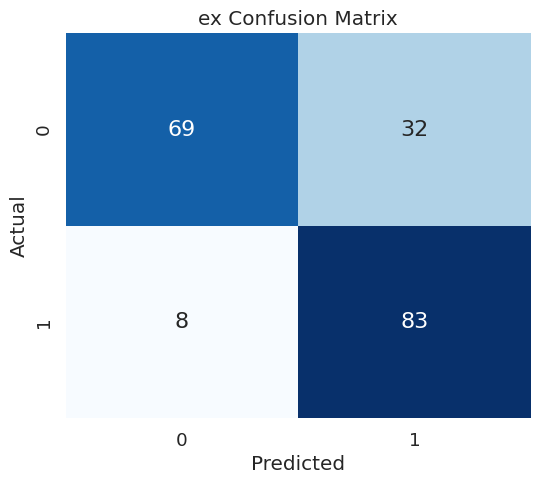

In [ ]:
ex_metrics = run_model('ex')

y_train value counts:
1    498
0    486
Name: empathy, dtype: int64
train_encodings:
{'input_ids': <tf.Tensor: shape=(984, 150), dtype=int32, numpy=
array([[    0,  2264,   817, ...,     1,     1,     1],
       [    0, 31414,   328, ...,     1,     1,     1],
       [    0,   713,   864, ...,     1,     1,     1],
       ...,
       [    0,  6179,    40, ...,     1,     1,     1],
       [    0,   100,  2854, ...,     1,     1,     1],
       [    0,  6179,   793, ...,     1,     1,     1]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(984, 150), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}
Epoch 1/10
123/123 [==============================] - 27s 138ms/step - loss: 0.6690 - accuracy: 0.6016 - val_loss: 0.5872 - val_accuracy: 0.8171
Epoch 2/10
123/123 [==============================] - 

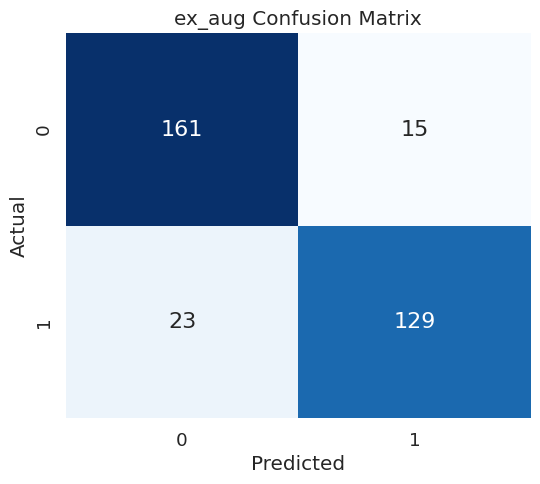

In [ ]:
ex_aug_metrics = run_model('ex_aug')

In [ ]:
metrics = pd.concat([em_metrics, in_metrics, ex_metrics, ex_aug_metrics], ignore_index=True)
print('RoBERTa Metrics')
display(metrics)

ValueError: ignored

# EM binary prediction with BERT (seeker + response)

In [ ]:
y_em_train, y_em_val, y_em_test = get_target_vectors('em')
y_em_train.value_counts()

0    629
1    627
Name: empathy, dtype: int64

In [ ]:
train_em_encodings, val_em_encodings, test_em_encodings = csv_to_encodings('em')
train_em_encodings

{'input_ids': <tf.Tensor: shape=(1256, 240), dtype=int32, numpy=
array([[ 101,  146,  112, ...,    0,    0,    0],
       [ 101, 1176, 2288, ...,    0,    0,    0],
       [ 101, 1109, 2501, ...,    0,    0,    0],
       ...,
       [ 101, 1192, 1132, ...,    0,    0,    0],
       [ 101, 1128, 9424, ...,    0,    0,    0],
       [ 101, 1337, 1122, ...,    0,    0,    0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1256, 240), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1256, 240), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

In [ ]:
em_classification = create_bert_binary_model(bert_model=bert_model)
em_classification_history = em_classification.fit([train_em_encodings.input_ids, train_em_encodings.token_type_ids, train_em_encodings.attention_mask],
                                                  y_em_train,
                                                  validation_data=([val_em_encodings.input_ids, val_em_encodings.token_type_ids, val_em_encodings.attention_mask],
                                                  y_em_val),
                                                  batch_size=8,
                                                  epochs=10,
                                                  #class_weight=class_weight_em
                                                  )

Epoch 1/10
157/157 [==============================] - 47s 228ms/step - loss: 0.5677 - accuracy: 0.7046 - val_loss: 0.4872 - val_accuracy: 0.7637
Epoch 2/10
157/157 [==============================] - 36s 227ms/step - loss: 0.4857 - accuracy: 0.7691 - val_loss: 0.4820 - val_accuracy: 0.7900
Epoch 3/10
157/157 [==============================] - 34s 217ms/step - loss: 0.4789 - accuracy: 0.7763 - val_loss: 0.5455 - val_accuracy: 0.7232
Epoch 4/10
157/157 [==============================] - 31s 200ms/step - loss: 0.4725 - accuracy: 0.7779 - val_loss: 0.4667 - val_accuracy: 0.7852
Epoch 5/10
157/157 [==============================] - 32s 203ms/step - loss: 0.4511 - accuracy: 0.7906 - val_loss: 0.4674 - val_accuracy: 0.7757
Epoch 6/10
157/157 [==============================] - 34s 215ms/step - loss: 0.4470 - accuracy: 0.7771 - val_loss: 0.4730 - val_accuracy: 0.7900
Epoch 7/10
157/157 [==============================] - 34s 217ms/step - loss: 0.4381 - accuracy: 0.7858 - val_loss: 0.4811 - val_ac

In [ ]:
predictions_em = em_classification.predict([test_em_encodings.input_ids, test_em_encodings.token_type_ids, test_em_encodings.attention_mask])
predictions_em = (predictions_em >= 0.5).astype(int)

14/14 [==============================] - 10s 517ms/step


In [ ]:
accuracy_em = accuracy_score(y_em_test, predictions_em)
print(f"accuracy for test: {accuracy_em}")
recall_em = recall_score(y_em_test, predictions_em)
print(f"recall for test: {recall_em}")
precision_em = precision_score(y_em_test, predictions_em)
print(f"precision for test: {precision_em}")
f1_em = f1_score(y_em_test, predictions_em)
print(f"f1 score for test: {f1_em}")

accuracy for test: 0.7852028639618138
recall for test: 0.8109452736318408
precision for test: 0.7581395348837209
f1 score for test: 0.783653846153846


[[166  52]
 [ 38 163]]


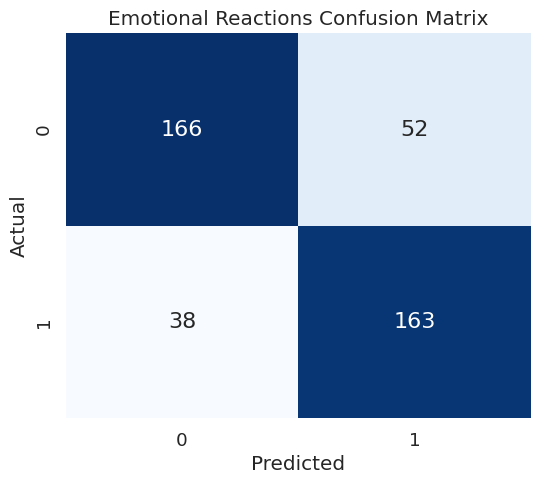

In [ ]:
conf_matrix_em = confusion_matrix(y_em_test, predictions_em)
print(conf_matrix_em)

sns.set(font_scale=1.2)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_em, annot=True, fmt='g', cmap='Blues', annot_kws={"size": 16}, cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Emotional Reactions Confusion Matrix')
plt.show()

# IN binary prediction

In [ ]:
y_in_train, y_in_val, y_in_test = get_target_vectors('in')
y_in_train.value_counts()

0    972
1    878
Name: empathy, dtype: int64

In [ ]:
train_in_encodings, val_in_encodings, test_in_encodings = csv_to_encodings('in')
train_in_encodings

{'input_ids': <tf.Tensor: shape=(1850, 240), dtype=int32, numpy=
array([[  101,  2140,   117, ...,     0,     0,     0],
       [  101,  4373,  1128, ...,     0,     0,     0],
       [  101,   168,  7595, ...,  4847,  1358,   102],
       ...,
       [  101, 14060,   119, ...,     0,     0,     0],
       [  101,  1284,   112, ...,     0,     0,     0],
       [  101, 10560,  1176, ...,     0,     0,     0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1850, 240), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1850, 240), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=in

In [ ]:
in_classification = create_bert_binary_model(bert_model=bert_model)
in_classification_history = in_classification.fit([train_in_encodings.input_ids, train_in_encodings.token_type_ids, train_in_encodings.attention_mask],
                                                  y_in_train,
                                                  validation_data=([val_in_encodings.input_ids, val_in_encodings.token_type_ids, val_in_encodings.attention_mask],
                                                  y_in_val),
                                                  batch_size=8,
                                                  epochs=10,
                                                  #class_weight=class_weight_em
                                                  )

Epoch 1/10
232/232 [==============================] - 54s 166ms/step - loss: 0.5720 - accuracy: 0.6924 - val_loss: 0.4928 - val_accuracy: 0.7650
Epoch 2/10
232/232 [==============================] - 31s 135ms/step - loss: 0.4853 - accuracy: 0.7622 - val_loss: 0.4740 - val_accuracy: 0.7828
Epoch 3/10
232/232 [==============================] - 34s 147ms/step - loss: 0.4593 - accuracy: 0.7811 - val_loss: 0.4812 - val_accuracy: 0.7747
Epoch 4/10
232/232 [==============================] - 35s 149ms/step - loss: 0.4537 - accuracy: 0.7800 - val_loss: 0.4698 - val_accuracy: 0.7844
Epoch 5/10
232/232 [==============================] - 34s 149ms/step - loss: 0.4464 - accuracy: 0.7941 - val_loss: 0.4688 - val_accuracy: 0.7909
Epoch 6/10
232/232 [==============================] - 34s 147ms/step - loss: 0.4336 - accuracy: 0.7995 - val_loss: 0.4651 - val_accuracy: 0.7942
Epoch 7/10
232/232 [==============================] - 31s 135ms/step - loss: 0.4225 - accuracy: 0.8011 - val_loss: 0.4860 - val_ac

In [ ]:
predictions_in = in_classification.predict([test_in_encodings.input_ids, test_in_encodings.token_type_ids, test_in_encodings.attention_mask])
predictions_in = (predictions_in >= 0.5).astype(int)

20/20 [==============================] - 10s 313ms/step


In [ ]:
accuracy_in = accuracy_score(y_in_test, predictions_in)
print(f"accuracy for test: {accuracy_in}")
recall_in = recall_score(y_in_test, predictions_in)
print(f"recall for test: {recall_in}")
precision_in = precision_score(y_in_test, predictions_in)
print(f"precision for test: {precision_in}")
f1_in = f1_score(y_in_test, predictions_in)
print(f"f1 score for test: {f1_in}")

[[270  61]
 [ 52 234]]


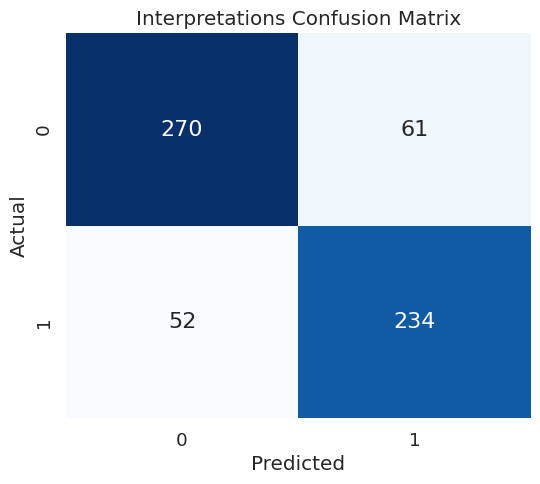

In [ ]:
conf_matrix_in = confusion_matrix(y_in_test, predictions_in)
print(conf_matrix_in)

sns.set(font_scale=1.2)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_in, annot=True, fmt='g', cmap='Blues', annot_kws={"size": 16}, cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Interpretations Confusion Matrix')
plt.show()

# Ex binary prediction (response)

In [ ]:
y_ex_train, y_ex_val, y_ex_test = get_target_vectors('ex')
y_ex_train.value_counts()

1    294
0    282
Name: empathy, dtype: int64

In [ ]:
train_ex_encodings, val_ex_encodings, test_ex_encodings = csv_to_encodings('ex')
train_ex_encodings

{'input_ids': <tf.Tensor: shape=(576, 150), dtype=int32, numpy=
array([[ 101,  146, 3668, ...,    0,    0,    0],
       [ 101, 1302, 1274, ...,    0,    0,    0],
       [ 101, 7595,  117, ...,    0,    0,    0],
       ...,
       [ 101, 2160, 1936, ...,    0,    0,    0],
       [ 101, 1135, 1281, ...,    0,    0,    0],
       [ 101, 8790, 1910, ..., 9655,  119,  102]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(576, 150), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(576, 150), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int32)>}

In [ ]:
ex_classification = create_bert_binary_model(bert_model=bert_model)
ex_classification_history = ex_classification.fit([train_ex_encodings.input_ids, train_ex_encodings.token_type_ids, train_ex_encodings.attention_mask],
                                                  y_ex_train,
                                                  validation_data=([val_ex_encodings.input_ids, val_ex_encodings.token_type_ids, val_ex_encodings.attention_mask],
                                                  y_ex_val),
                                                  batch_size=8,
                                                  epochs=10,
                                                  #class_weight=class_weight_em
                                                  )

Epoch 1/10
72/72 [==============================] - 18s 144ms/step - loss: 0.6357 - accuracy: 0.6441 - val_loss: 0.4504 - val_accuracy: 0.8229
Epoch 2/10
72/72 [==============================] - 9s 120ms/step - loss: 0.4564 - accuracy: 0.8073 - val_loss: 0.3957 - val_accuracy: 0.8385
Epoch 3/10
72/72 [==============================] - 9s 129ms/step - loss: 0.4094 - accuracy: 0.8073 - val_loss: 0.3393 - val_accuracy: 0.8438
Epoch 4/10
72/72 [==============================] - 9s 122ms/step - loss: 0.4000 - accuracy: 0.8316 - val_loss: 0.3553 - val_accuracy: 0.8698
Epoch 5/10
72/72 [==============================] - 9s 119ms/step - loss: 0.3410 - accuracy: 0.8646 - val_loss: 0.3198 - val_accuracy: 0.8385
Epoch 6/10
72/72 [==============================] - 8s 118ms/step - loss: 0.3542 - accuracy: 0.8524 - val_loss: 0.3519 - val_accuracy: 0.8281
Epoch 7/10
72/72 [==============================] - 9s 125ms/step - loss: 0.3582 - accuracy: 0.8333 - val_loss: 0.3256 - val_accuracy: 0.8750
Epoch

In [ ]:
predictions_ex = ex_classification.predict([test_ex_encodings.input_ids, test_ex_encodings.token_type_ids, test_ex_encodings.attention_mask])
predictions_ex = (predictions_ex >= 0.5).astype(int)

In [ ]:
accuracy_ex = accuracy_score(y_ex_test, predictions_ex)
print(f"accuracy for test: {accuracy_ex}")
recall_ex = recall_score(y_ex_test, predictions_ex)
print(f"recall for test: {recall_ex}")
precision_ex = precision_score(y_ex_test, predictions_ex)
print(f"precision for test: {precision_ex}")
f1_ex = f1_score(y_ex_test, predictions_ex)
print(f"f1 score for test: {f1_ex}")

In [ ]:
conf_matrix_ex = confusion_matrix(y_ex_test, predictions_ex)
print(conf_matrix_ex)

sns.set(font_scale=1.2)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_ex, annot=True, fmt='g', cmap='Blues', annot_kws={"size": 16}, cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Explorations Confusion Matrix')
plt.show()

# Ex aug binary prediction (response)

In [ ]:
y_ex_aug_train, y_ex_aug_val, y_ex_aug_test = get_target_vectors('ex_aug')
y_ex_aug_train.value_counts()

1    498
0    486
Name: empathy, dtype: int64

In [ ]:
train_ex_aug_encodings, val_ex_aug_encodings, test_ex_aug_encodings = csv_to_encodings('ex_aug')
train_ex_aug_encodings

{'input_ids': <tf.Tensor: shape=(984, 150), dtype=int32, numpy=
array([[ 101, 1327, 2228, ...,    0,    0,    0],
       [ 101, 8667,  106, ...,    0,    0,    0],
       [ 101, 1188, 2304, ...,    0,    0,    0],
       ...,
       [ 101, 1731, 1209, ...,    0,    0,    0],
       [ 101,  146, 5340, ...,    0,    0,    0],
       [ 101, 1731, 1385, ...,    0,    0,    0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(984, 150), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(984, 150), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

In [ ]:
ex_aug_classification = create_bert_binary_model(bert_model=bert_model)
ex_aug_classification_history = ex_aug_classification.fit([train_ex_aug_encodings.input_ids, train_ex_aug_encodings.token_type_ids, train_ex_aug_encodings.attention_mask],
                                                  y_ex_aug_train,
                                                  validation_data=([val_ex_aug_encodings.input_ids, val_ex_aug_encodings.token_type_ids, val_ex_aug_encodings.attention_mask],
                                                  y_ex_aug_val),
                                                  batch_size=8,
                                                  epochs=10,
                                                  #class_weight=class_weight_em
                                                  )

Epoch 1/10
123/123 [==============================] - 42s 170ms/step - loss: 0.5384 - accuracy: 0.7083 - val_loss: 0.4150 - val_accuracy: 0.7988
Epoch 2/10
123/123 [==============================] - 17s 138ms/step - loss: 0.4141 - accuracy: 0.8059 - val_loss: 0.3687 - val_accuracy: 0.8323
Epoch 3/10
123/123 [==============================] - 15s 124ms/step - loss: 0.3555 - accuracy: 0.8557 - val_loss: 0.4084 - val_accuracy: 0.7927
Epoch 4/10
123/123 [==============================] - 16s 130ms/step - loss: 0.3476 - accuracy: 0.8638 - val_loss: 0.3518 - val_accuracy: 0.8415
Epoch 5/10
123/123 [==============================] - 17s 141ms/step - loss: 0.3394 - accuracy: 0.8659 - val_loss: 0.3301 - val_accuracy: 0.8384
Epoch 6/10
123/123 [==============================] - 17s 137ms/step - loss: 0.3255 - accuracy: 0.8740 - val_loss: 0.3191 - val_accuracy: 0.8537
Epoch 7/10
123/123 [==============================] - 16s 130ms/step - loss: 0.3075 - accuracy: 0.8791 - val_loss: 0.3193 - val_ac

In [ ]:
predictions_ex_aug = ex_aug_classification.predict([test_ex_aug_encodings.input_ids, test_ex_aug_encodings.token_type_ids, test_ex_aug_encodings.attention_mask])
predictions_ex_aug = (predictions_ex_aug >= 0.5).astype(int)

11/11 [==============================] - 7s 309ms/step


In [ ]:
accuracy_ex_aug = accuracy_score(y_ex_aug_test, predictions_ex_aug)
print(f"accuracy for test: {accuracy_ex_aug}")
recall_ex_aug = recall_score(y_ex_aug_test, predictions_ex_aug)
print(f"recall for test: {recall_ex_aug}")
precision_ex_aug = precision_score(y_ex_aug_test, predictions_ex_aug)
print(f"precision for test: {precision_ex_aug}")
f1_ex_aug = f1_score(y_ex_aug_test, predictions_ex_aug)
print(f"f1 score for test: {f1_ex_aug}")

accuracy for test: 0.8597560975609756
recall for test: 0.8026315789473685
precision for test: 0.8840579710144928
f1 score for test: 0.8413793103448277


[[160  16]
 [ 30 122]]


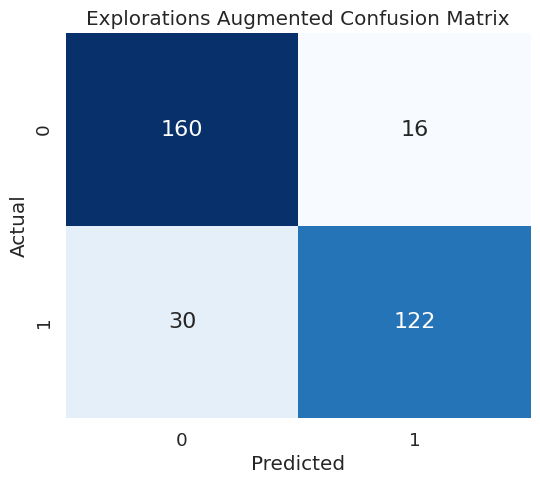

In [ ]:
conf_matrix_ex_aug = confusion_matrix(y_ex_aug_test, predictions_ex_aug)
print(conf_matrix_ex_aug)

sns.set(font_scale=1.2)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_ex_aug, annot=True, fmt='g', cmap='Blues', annot_kws={"size": 16}, cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Explorations Augmented Confusion Matrix')
plt.show()

# summary

In [ ]:
metrics = {
    'Category': ['em', 'in', 'ex', 'ex_aug'],
    'Accuracy': [accuracy_em, accuracy_in, accuracy_ex, accuracy_ex_aug],
    'Precision': [precision_em, precision_in, precision_ex, precision_ex_aug],
    'Recall': [recall_em, recall_in, recall_ex, recall_ex_aug],
    'F1 Score': [f1_em, f1_in, f1_ex, f1_ex_aug]
}

metrics_df = pd.DataFrame(metrics)

metrics_df

,Category,Accuracy,Precision,Recall,F1 Score
0,em,0.768496,0.837662,0.641791,0.726761
1,in,0.816856,0.793220,0.818182,0.805508
2,ex,0.833333,0.831461,0.813187,0.822222
3,ex_aug,0.859756,0.884058,0.802632,0.841379
